In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
import pandas as pd
pd.options.display.max_columns = None

import numpy as np
import os

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
class Icare:
    def __init__(self,data_folder):
        self.data_folder = data_folder
        self.diagnoses_path = 'LS_ANALYTICS.ICARE_CLINICO_DIAGNOSTICOS/index.csv'
        self.atividade_path = 'LS_ANALYTICS.ICARE_ATIVIDADE_HOSPITALAR/index.csv'
        
    
    def _read_diagnoses(self):
        print('Reading diagnostics table...')
        diagnoses_file = os.path.join(self.data_folder,self.diagnoses_path)
        
        df = pd.read_csv(diagnoses_file,sep='\t')
        
        print('begining: ',round(df.memory_usage(index=True).sum() / 1_000_000,1),'Mb') #Mbytes
        
        df = df.drop(columns='UNIDADE')
        #print('drop UNIDADE:',df.memory_usage(index=True).sum() / 1_000_000) #Mbytes
        
        df = df.drop(columns='DATA_FIM')
        #print('drop date_end:',df.memory_usage(index=True).sum() / 1_000_000) #Mbytes
        
        df.loc[:,'PRIORIDADE_DIAGNOSTICO'] = df.PRIORIDADE_DIAGNOSTICO.astype('category')
        #print('PRIORIDADE_DIAGNOSTICO to category:',df.memory_usage(index=True).sum() / 1_000_000) #Mbytes
        
        df = df.drop(columns=['ICD9_DESCRICAO'])
        #print('drop icd9_descricao:',df.memory_usage(index=True).sum() / 1_000_000) #Mbytes
        
        df.loc[:,'DIAGNOSTICO_PRINCIPAL'] = df.DIAGNOSTICO_PRINCIPAL.map({'S':True,'N':False})        
        #print('DIAGNOSTICO_PRINCIPAL to boolean:',df.memory_usage(index=True).sum() / 1_000_000) #Mbytes
        
        # a single row with the year 9064 ruins pd.to_datetime (overflow since pandas uses miliseconds in dates)
        # tldr:  we will remove that row
        nrows_before = df.shape[0]
        df = df.drop(df.DATA_INICIO.apply(lambda x: x[:4] if x is not np.nan else x).astype(float).where(lambda x: x==9064.0).dropna().index[0])
        nrows_after = df.shape[0]
        assert nrows_before == nrows_after + 1, 'Ooops, expecting to drop exactly 1 row. maybe dataset changed.'
        
        df.loc[:,'DATA_INICIO'] = pd.to_datetime(df.DATA_INICIO,format='%Y-%m-%d %H:%M:%S')
        #print('DATA_INICIO to datetime:',df.memory_usage(index=True).sum() / 1_000_000) #Mbytes
        
        df = df.drop_duplicates()
        #print('drop duplicates:',df.memory_usage(index=True).sum() / 1_000_000) #Mbytes
        
        # last row is trash
        df = df.iloc[:-1]
        
        print('end: ',round(df.memory_usage(index=True).sum() / 1_000_000),'Mb') #Mbytes
        print('Done')
        return df
        

In [4]:
icare = Icare('../../icare-dataset_2021-08')
df = icare._read_diagnoses()
df.head(1)

Reading diagnostics table...


/tmp/ipykernel_4232/365396413.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(diagnoses_file,sep='\t')


begining:  178.9 Mb
end:  117 Mb
Done


,EPISODIO,NHC,PRIORIDADE_DIAGNOSTICO,ICD9,DIAGNOSTICO_PRINCIPAL,DATA_INICIO
0,9B91F36DDC2E5D45,7E0717CE88F09A1EB9B7CB48F3520501,ASAP,2578,True,2016-10-19 17:40:00


In [5]:
df.EPISODIO.nunique()

2155787

In [5]:
(df
 .groupby('NHC')
 .EPISODIO
 .nunique()
 .describe()
 .rename('Nº episodes per patient')
)

count    439108.000000
mean          4.909473
std           7.249056
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max         250.000000
Name: Nº episodes per patient, dtype: float64

In [6]:
((df
 .groupby('NHC')
 .DATA_INICIO
 .agg([max,min])
 .diff(periods=-1,axis=1)['max']
 .dt.days / 30)
 .round()
 .describe()
 .rename('timeline of appearance in data per patient (in months)')
)

count    439103.000000
mean         19.434433
std          27.319838
min           0.000000
25%           0.000000
50%           3.000000
75%          35.000000
max         307.000000
Name: timeline of appearance in data per patient (in months), dtype: float64

In [45]:
(pd.concat([df.EPISODIO.value_counts().value_counts().rename('Count'),
           df.EPISODIO.value_counts().value_counts(normalize=True).rename('Freq')
          ], axis=1
         )
 .round(2)
 .rename_axis('Diagnostics per episode')
)

,Count,Freq
Diagnostics per episode,,
1,1995192,0.93
2,117879,0.05
3,26146,0.01
4,8950,0.00
5,3913,0.00
6,1901,0.00
7,1004,0.00
8,414,0.00
9,203,0.00


## Findings

- Most episodes have only one diagnostic (93%)

<Figure size 864x288 with 0 Axes>

<AxesSubplot:title={'center':'Nº diagnósticos atribuidos ao longo do tempo'}, xlabel='DATA_INICIO'>

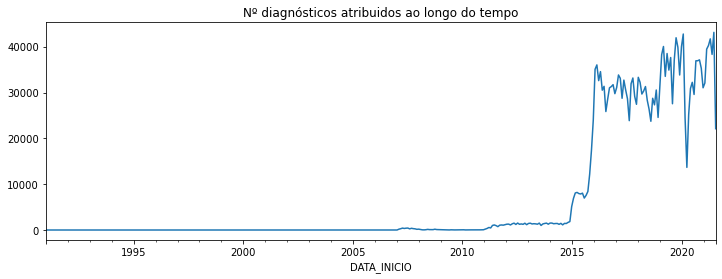

In [32]:
plt.figure(figsize=(12,4))
(df[~df.DATA_INICIO.isna()]
 .set_index('DATA_INICIO')
 .sort_index()
 .resample('30D')
 .size()
 .plot(title='Nº diagnósticos atribuidos ao longo do tempo')
)

# Findings

- A lot more diagnostics are registered after 2016

In [7]:
assert 1 == 2, 'Preventing myself to run this cell by accident'

all_res = pd.read_csv(
    'important_data/all_res.csv',
    sep='\t',
    dtype={'PRIORIDADE_DIAGNOSTICO':'category',
           'GENERO':'category',
           'TIPO_EPISODIO':'category',
           'ICD9':str},
    parse_dates=['DATA_HORA_ADMISSAO'],
    date_parser= lambda x: pd.to_datetime(x,format='%Y-%m-%d %H:%M:%S')
)
# convert this column to boolean
all_res['DIAGNOSTICO_PRINCIPAL'] = (all_res['DIAGNOSTICO_PRINCIPAL'] == 'True')

In [8]:
all_res.shape

(9402523, 11)

## Code to read atividade hospitalar

In [146]:
#assert 1 == 2, 'Preventing myself to run this cell by accident'

file = '../../icare-dataset_2021-08/LS_ANALYTICS.ICARE_ATIVIDADE_HOSPITALAR/index.csv'
all_res = None
i = 0 # to test a couple of chunks
count_hora_admissao_na = 0
with pd.read_csv(file,
                 sep='\t',
                 chunksize=1_000_000,
                 usecols=[0,2,3,4,5,7,8,13],
                 dtype={'UNIDADE':'category',
                        'GENERO':'category',
                        'TIPO_EPISODIO':'category',
                        'NHC':str,
                        'EPISODIO_INTERNAMENTO':str
                       },
                 parse_dates=['DATA_HORA_ADMISSAO'],
                 date_parser= lambda x: pd.to_datetime(x,format='%Y-%m-%d %H:%M:%S')
                ) as reader:
    for chunk in tqdm(reader):
        res = pd.merge(df,chunk,left_on='EPISODIO',right_on='EPISODIO',how='right',suffixes=('_drop',''))
        res = res.drop(columns=res.filter(like='_drop').columns)
        res = res.drop_duplicates()
        
        mask_hora_admissao_na = res.DATA_HORA_ADMISSAO.isna()
        count_hora_admissao_na += mask_hora_admissao_na.sum()
        res = res[~mask_hora_admissao_na]
        
        all_res = res if all_res is None else pd.concat([all_res,res])
        i +=1
        
        #if i >= 10:
        #    break
    all_res = all_res.drop_duplicates() # found out that some duplicates are created in between chunks

0it [00:00, ?it/s]

In [148]:
all_res.memory_usage(index=True).sum() / 1_000_000

780.409697

From 15Gb to 780Mb

In [36]:
{i:chunk.columns[i] for i in range(len(chunk.columns))}

{0: 'UNIDADE',
 1: 'DATA_ATIVIDADE',
 2: 'DATA_HORA_ADMISSAO',
 3: 'EPISODIO',
 4: 'EPISODIO_INTERNAMENTO',
 5: 'NHC',
 6: 'MPI',
 7: 'IDADE',
 8: 'GENERO',
 9: 'SERVICO_EPISODIO',
 10: 'ESPECIALIDADE',
 11: 'CODIGO_ATO_ARTIGO',
 12: 'DESCRICAO_ATO_ARTIGO',
 13: 'TIPO_EPISODIO',
 14: 'CODIGO_CLASSIFICADOR_BI',
 15: 'CLASSIFICADOR_BI',
 16: 'ESTADO_ACTO',
 17: 'OBITO',
 18: 'QUANTIDADE'}

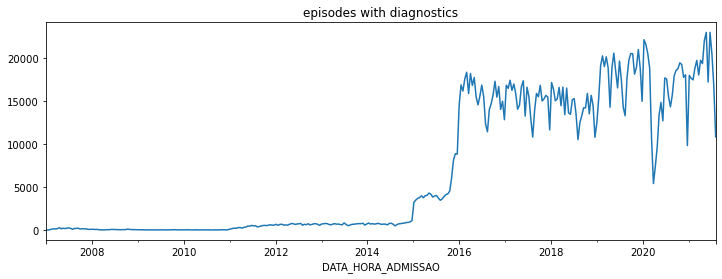

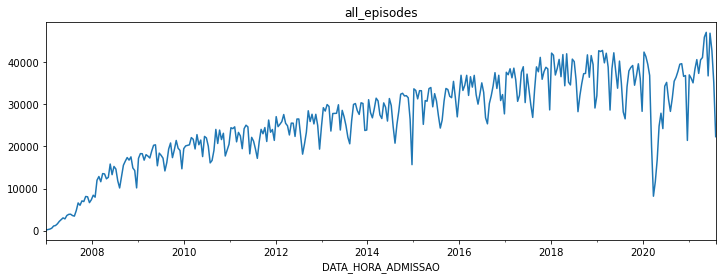

In [34]:
resampled = all_res.set_index(['DATA_HORA_ADMISSAO']).sort_index().resample('15D')
plt.figure(figsize=(12,4));
resampled.apply(lambda subdf: subdf[~subdf.ICD9.isna()].shape[0]).plot(title='episodes with diagnostics');
plt.show();

plt.figure(figsize=(12,4));
resampled.apply(lambda subdf:subdf.shape[0])['EPISODIO'].plot(title='all_episodes');
plt.show();

----